In [1]:
import warnings

import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid

pd.plotting.register_matplotlib_converters()

warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from pmdarima import auto_arima

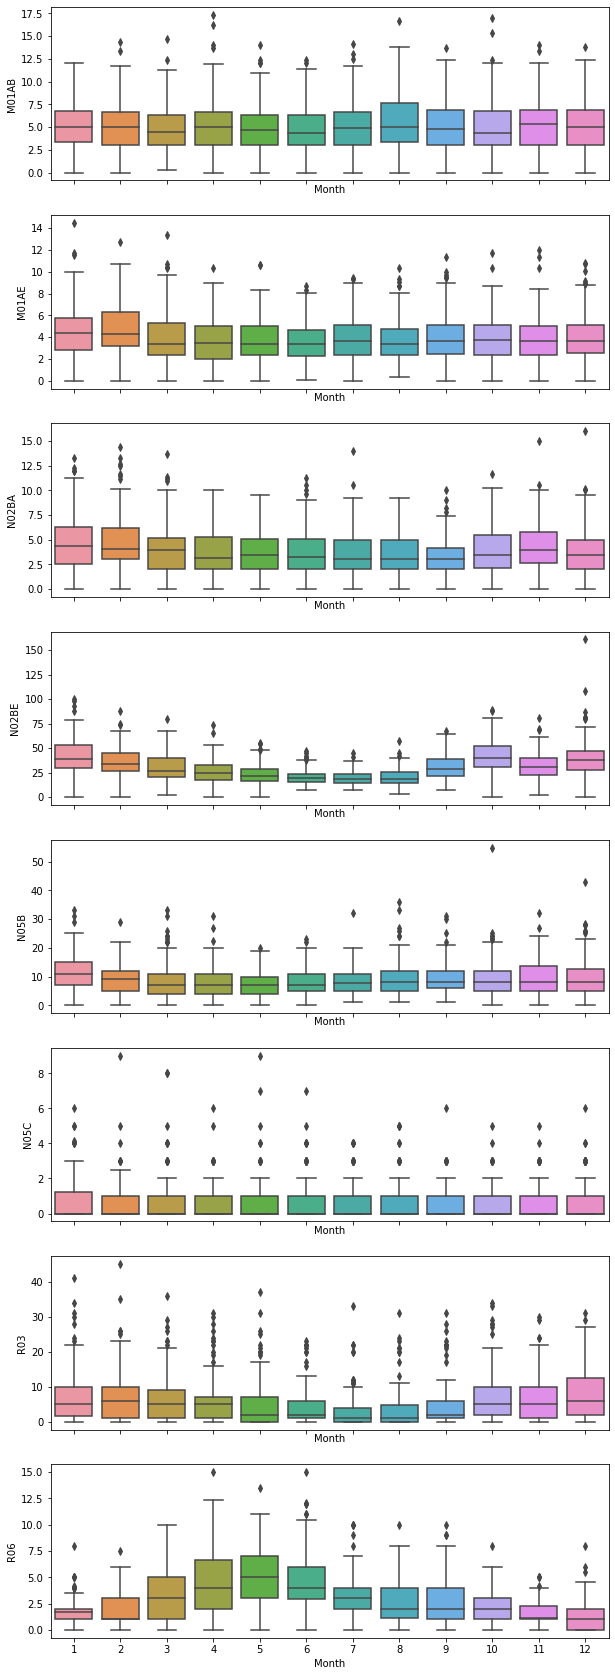

In [4]:
import seaborn as sns
dfatc_daily = pd.read_csv('salesdaily.csv')
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='Month', y=name, ax=ax)


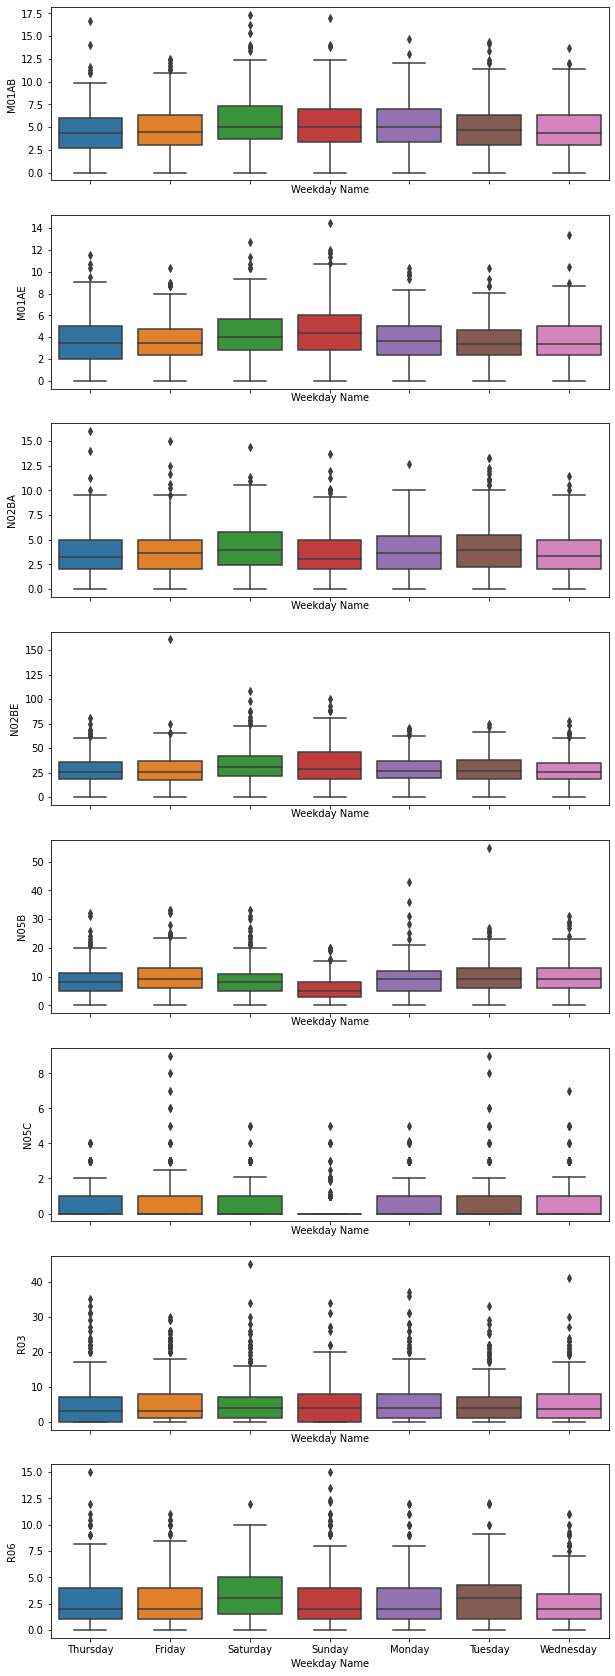

In [5]:
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='Weekday Name', y=name, ax=ax)

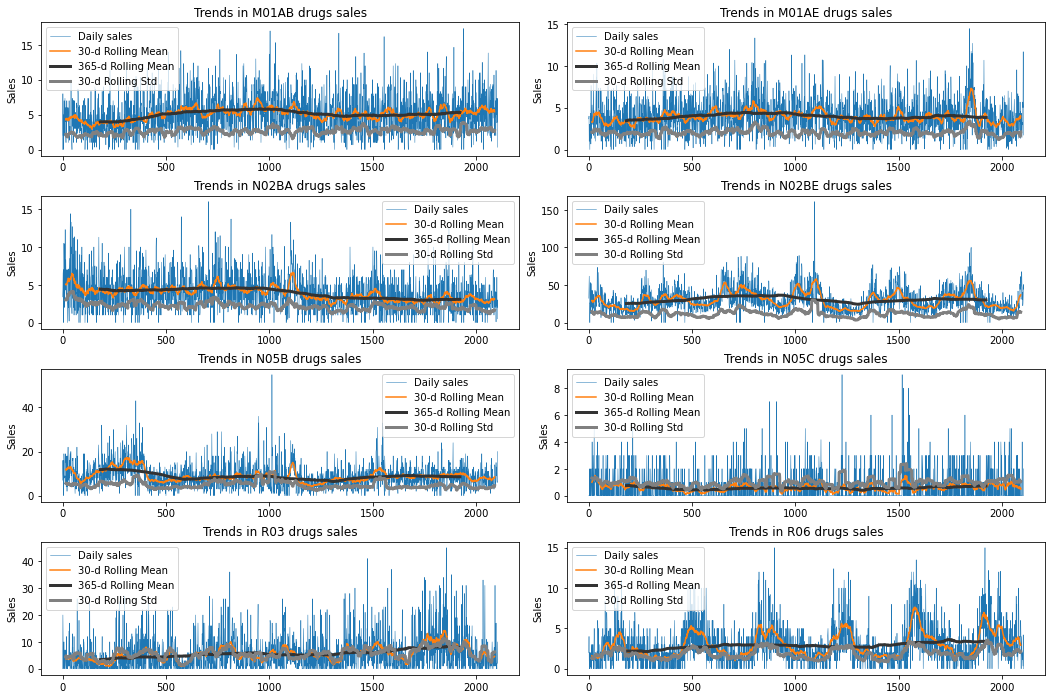

In [6]:
dfatc_daily=pd.read_csv('salesdaily.csv')
cols_plot = ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']
dfatc_365d = dfatc_daily[cols_plot].rolling(window=365, center=True).mean()
dfatc_30d = dfatc_daily[cols_plot].rolling(30, center=True).mean()
dfatc_std = dfatc_daily[cols_plot].rolling(30, center=True).std()
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for x in cols_plot:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ax[rowindex,colindex].plot(dfatc_daily.loc[:,x], linewidth=0.5, label='Daily sales')
    ax[rowindex,colindex].plot(dfatc_30d.loc[:,x], label='30-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_365d.loc[:,x], color='0.2', linewidth=3, label='365-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_std.loc[:,x], color='0.5', linewidth=3, label='30-d Rolling Std')
    ax[rowindex,colindex].set_ylabel('Sales')
    ax[rowindex,colindex].legend()
    ax[rowindex,colindex].set_title('Trends in '+x+' drugs sales');   
    subplotindex=subplotindex+1
plt.show()

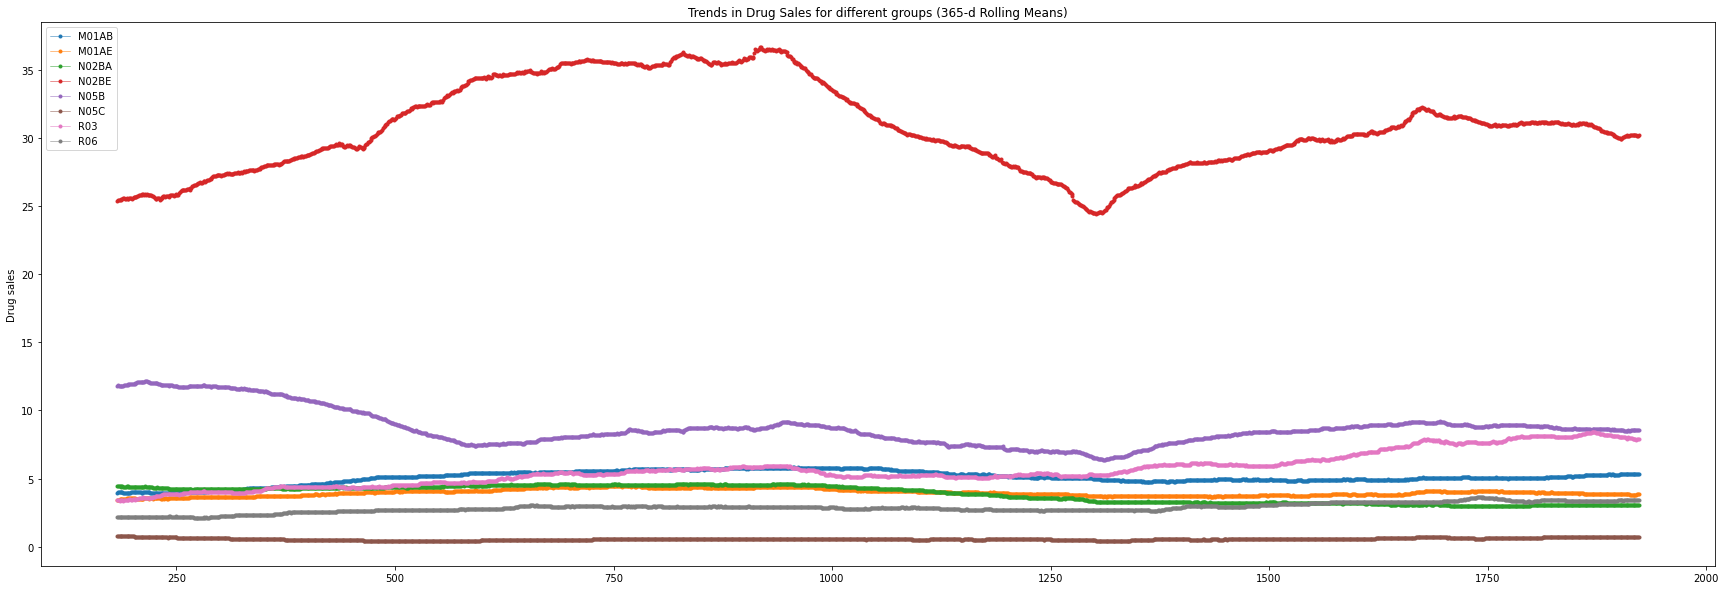

In [7]:
fig, ax = plt.subplots(figsize=(30, 10))
for nm in cols_plot:
    ax.plot(dfatc_365d[nm], label=nm, marker='.', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.set_ylabel('Drug sales')
    ax.set_title('Trends in Drug Sales for different groups (365-d Rolling Means)');

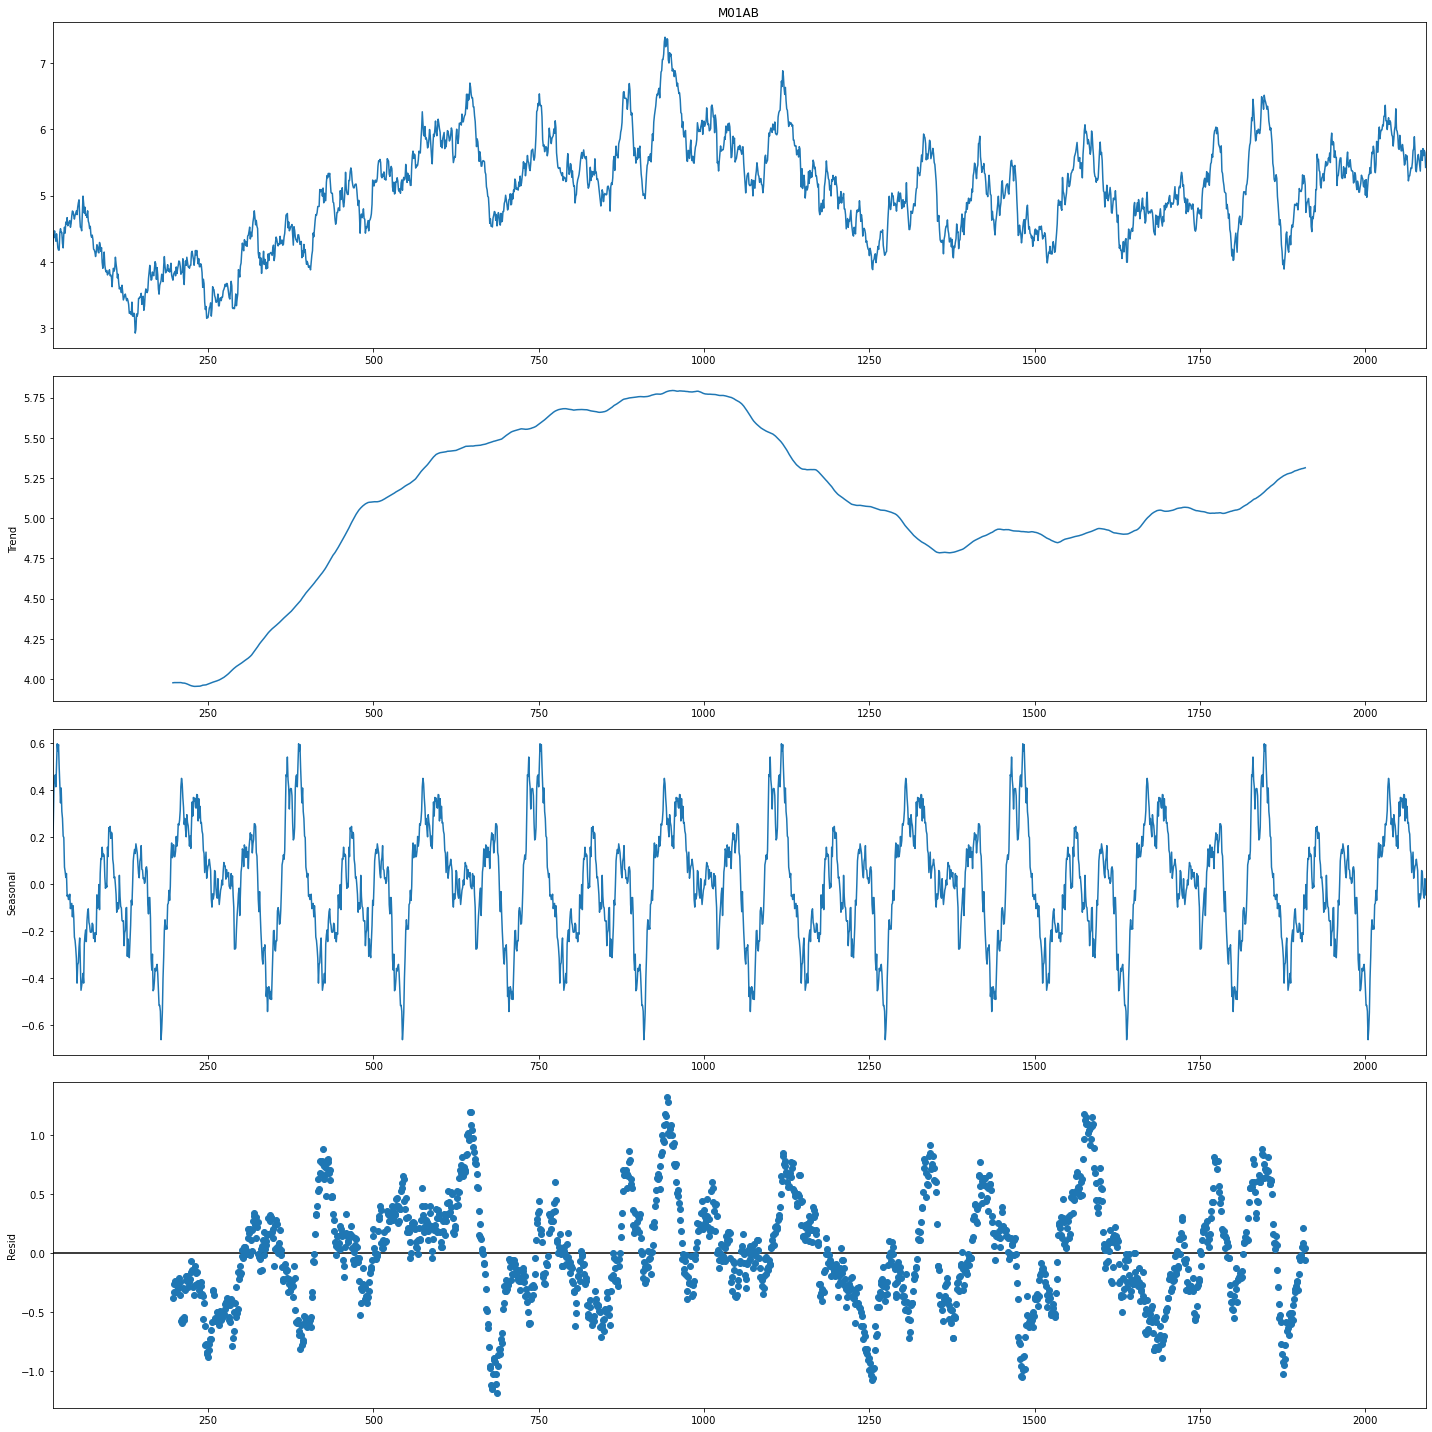

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming the index of dfatc_daily['M01AB'] is a datetime index
result = seasonal_decompose(dfatc_daily['M01AB'].rolling(30, center=True).mean().dropna(), period=365, filt=None)

plt.rcParams["figure.figsize"] = (20, 20)
result.plot()
plt.show()

In [9]:
df = pd.read_csv('salesweekly.csv')
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    result = seasonal_decompose(df[x], period=52, model='additive')
    dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)
    dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
    dfs=dfs.dropna()
    res=dfs['residuals'].values
    obs=dfs['observed'].values
    resmean=np.mean(np.abs(res))
    obsmean=np.mean(np.abs(obs))
    perc=resmean*100/obsmean
    print(x+' RESMEAN:'+str(resmean)+', OBSMEAN:'+str(obsmean)+', PERC:'+str(perc)+'%')

M01AB RESMEAN:5.26715996284115, OBSMEAN:35.59490833332001, PERC:14.797509558159527%
M01AE RESMEAN:4.319542609675869, OBSMEAN:28.00801458336, PERC:15.422523423856601%
N02BA RESMEAN:3.9228389592521657, OBSMEAN:27.083016, PERC:14.484498178682042%
N02BE RESMEAN:29.534357236963668, OBSMEAN:217.6597028336, PERC:13.569051529737028%
N05B RESMEAN:12.948403059321247, OBSMEAN:61.96614999972, PERC:20.89592956699707%
N05C RESMEAN:2.0384606385595405, OBSMEAN:3.871833333332, PERC:52.648460382081936%
R03 RESMEAN:11.72224433554451, OBSMEAN:40.06845833336, PERC:29.255541199060463%
R06 RESMEAN:4.278758416393867, OBSMEAN:19.744589999960002, PERC:21.670535657628417%


In [10]:
df=pd.read_csv('salesweekly.csv')
from statsmodels.tsa.stattools import adfuller

for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    dftest = adfuller(df[x], regression='ct', autolag='AIC')
    print("ADF test for "+x)
    print("-----------------------------")
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

ADF test for M01AB
-----------------------------
Test statistic = -3.700
P-value = 0.022
Critical values :
	1%: -3.9897903649837616 - The data is not stationary with 99% confidence
	5%: -3.425478311521626 - The data is  stationary with 95% confidence
	10%: -3.1358607194990724 - The data is  stationary with 90% confidence
ADF test for M01AE
-----------------------------
Test statistic = -8.717
P-value = 0.000
Critical values :
	1%: -3.98926783537037 - The data is  stationary with 99% confidence
	5%: -3.425226747185185 - The data is  stationary with 95% confidence
	10%: -3.1357131066666666 - The data is  stationary with 90% confidence
ADF test for N02BA
-----------------------------
Test statistic = -2.670
P-value = 0.249
Critical values :
	1%: -3.990441532957606 - The data is not stationary with 99% confidence
	5%: -3.425791763669738 - The data is not stationary with 95% confidence
	10%: -3.1360446341572343 - The data is not stationary with 90% confidence
ADF test for N02BE
------------

In [11]:
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import kpss

# Read the CSV file and handle missing values
df = pd.read_csv('salesweekly.csv').fillna(method='ffill')  # Fill missing values using forward fill

# Iterate through the columns and perform KPSS tests with error handling
for x in ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']:
    print(" > Is " + x + " data stationary?")

    try:
        # Ensure log-transformed data is of type float and handle potential zero values
        log_data = np.log(df[x]).replace(-np.inf, np.nan).replace(to_replace=np.nan, value=0).astype(float)

        # Perform the KPSS test
        dftest = kpss(log_data, 'ct')

        print("Test statistic = {:.3f}".format(dftest[0]))
        print("P-value = {:.3f}".format(dftest[1]))
        print("Critical values:")
        for k, v in dftest[3].items():
            print("\t{}: {}".format(k, v))

    except Exception as e:
        print(f"An error occurred while testing for stationarity in column '{x}': {e}")

 > Is M01AB data stationary?
Test statistic = 0.469
P-value = 0.010
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is M01AE data stationary?
Test statistic = 0.347
P-value = 0.010
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N02BA data stationary?
Test statistic = 0.233
P-value = 0.010
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N02BE data stationary?
Test statistic = 0.095
P-value = 0.100
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N05B data stationary?
Test statistic = 0.197
P-value = 0.017
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is N05C data stationary?
Test statistic = 0.268
P-value = 0.010
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is R03 data stationary?
Test statistic = 0.055
P-value = 0.100
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is R06 data stationary?
Test statistic = 0.032
P-value = 0.100
Critical value

D:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
D:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
D:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
D:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
D:\A

In [12]:
df = pd.read_csv('salesweekly.csv')    
def ApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))
    N = len(U)
    return abs(_phi(m+1) - _phi(m))

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    print(x + ': ' + str(ApEn(df[x].values, m=2, r=0.2*np.std(df[x].values))))

M01AB: 1.141130089570642
M01AE: 1.166363924596575
N02BA: 1.1370638730125302
N02BE: 1.058024809082593
N05B: 1.074437415034502
N05C: 1.0361887401424648
R03: 1.1847216239035152
R06: 1.031759595747876


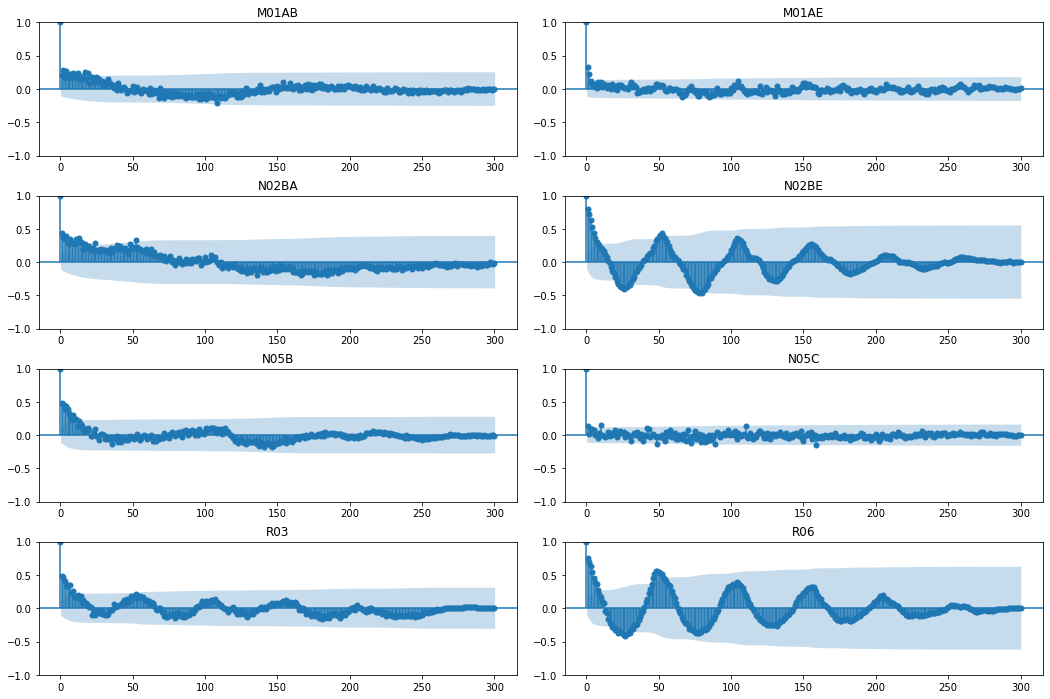

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
df = pd.read_csv('salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(18,12))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_acf(df[x], lags=300, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

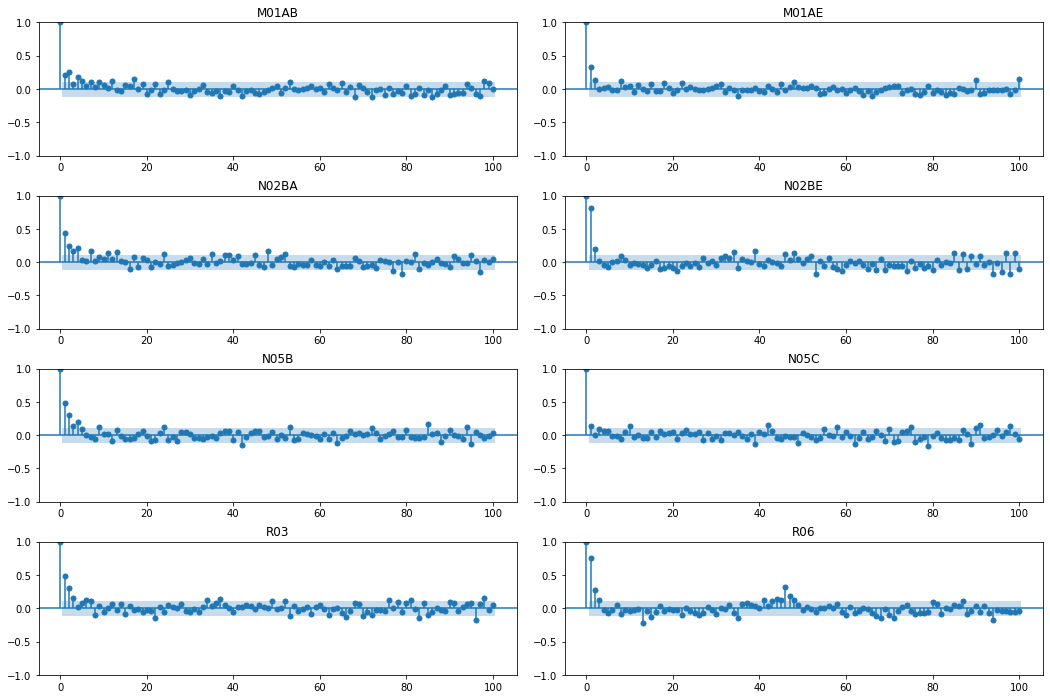

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
df = pd.read_csv('salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_pacf(df[x], lags=100, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

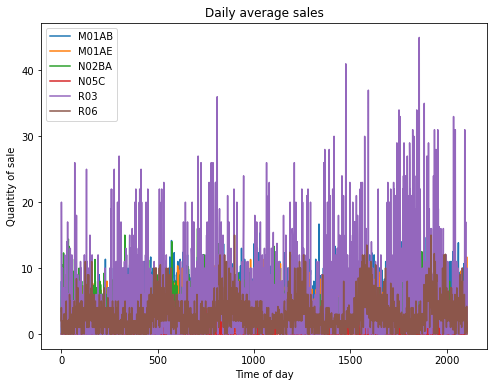

In [15]:
dfatch=pd.read_csv('saleshourly.csv')
dfatch['datum']= pd.to_datetime(dfatch['datum']) 

grp1=dfatch.groupby(dfatch.datum.dt.hour)['M01AB']
grp2=dfatch.groupby(dfatch.datum.dt.hour)['M01AE']
grp3=dfatch.groupby(dfatch.datum.dt.hour)['N02BA']
grp6=dfatch.groupby(dfatch.datum.dt.hour)['N05C']
grp7=dfatch.groupby(dfatch.datum.dt.hour)['R03']
grp8=dfatch.groupby(dfatch.datum.dt.hour)['R06']

plt.title('Daily average sales')
plt.xlabel('Time of day')
plt.ylabel('Quantity of sale')

grp1.plot(figsize=(8,6))
grp2.plot(figsize=(8,6))
grp3.plot(figsize=(8,6))
grp6.plot(figsize=(8,6))
grp7.plot(figsize=(8,6))
grp8.plot(figsize=(8,6))

plt.legend(['M01AB', 'M01AE', 'N02BA', 'N05C', 'R03', 'R06'], loc='upper left')

plt.show()


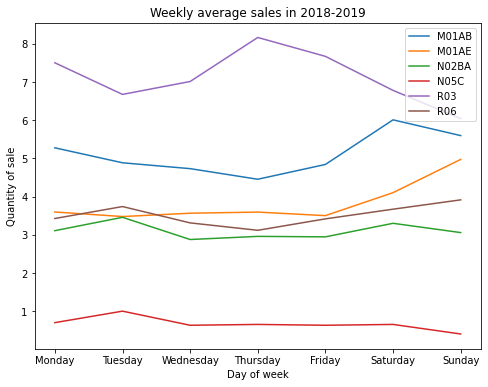

In [16]:
dfatcw=pd.read_csv('salesdaily.csv')
dfatcw['datum']= pd.to_datetime(dfatcw['datum'])
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.rcParams.update({'font.size': 10})

grp1 = dfatcw.loc[dfatcw['datum'].dt.year >= 2018].groupby(dfatcw['datum'].dt.day_name())['M01AB'].mean().reindex(days)

grp2 = dfatcw.loc[dfatcw['datum'].dt.year >= 2018].groupby(dfatcw['datum'].dt.day_name())['M01AE'].mean().reindex(days)
grp3=dfatcw.loc[dfatcw['datum'].dt.year >= 2018].groupby(dfatcw['datum'].dt.day_name())['N02BA'].mean().reindex(days)
grp6=dfatcw.loc[dfatcw['datum'].dt.year >= 2018].groupby(dfatcw['datum'].dt.day_name())['N05C'].mean().reindex(days)
grp7=dfatcw.loc[dfatcw['datum'].dt.year >= 2018].groupby(dfatcw['datum'].dt.day_name())['R03'].mean().reindex(days)
grp8=dfatcw.loc[dfatcw['datum'].dt.year >= 2018].groupby(dfatcw['datum'].dt.day_name())['R06'].mean().reindex(days)

grp1.plot(figsize=(8,6))
grp2.plot(figsize=(8,6))
grp3.plot(figsize=(8,6))
grp6.plot(figsize=(8,6))
grp7.plot(figsize=(8,6))
grp8.plot(figsize=(8,6))

plt.legend(['M01AB', 'M01AE', 'N02BA', 'N05C', 'R03', 'R06'], loc='upper right')
plt.title('Weekly average sales in 2018-2019')
plt.xlabel('Day of week')
plt.ylabel('Quantity of sale')

plt.show()

In [17]:
resultsRolling={'M01AB':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'M01AE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BA':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05B':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05C':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R03':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R06':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]}
resultsRollingdf = pd.DataFrame(resultsRolling)
resultsRollingdf.index = ['Naive MSE', 'Naive MAPE', 'Seasonal Naive MSE', 'Seasonal Naive MAPE', 
                          'ARIMA MSE', 'ARIMA MAPE', 'AutoARIMA MSE', 'AutoARIMA MAPE',
                         'Prophet MSE', 'Prophet MAPE']
resultsLongterm={'M01AB':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'M01AE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BA':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05B':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05C':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R03':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R06':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]}
resultsLongtermdf = pd.DataFrame(resultsLongterm)
resultsLongtermdf.index = ['Average MSE', 'Average MAPE', 'ARIMA MSE', 'ARIMA MAPE', 
                           'AutoARIMA MSE', 'AutoARIMA MAPE', 'Prophet MSE', 'Prophet MAPE',
                          'Vanilla LSTM MSE', 'Vanilla LSTM MAPE', 'Stacked LSTM MSE', 'Stacked LSTM MAPE',
                          'Bidirectional LSTM MSE', 'Bidirectional LSTM MAPE']

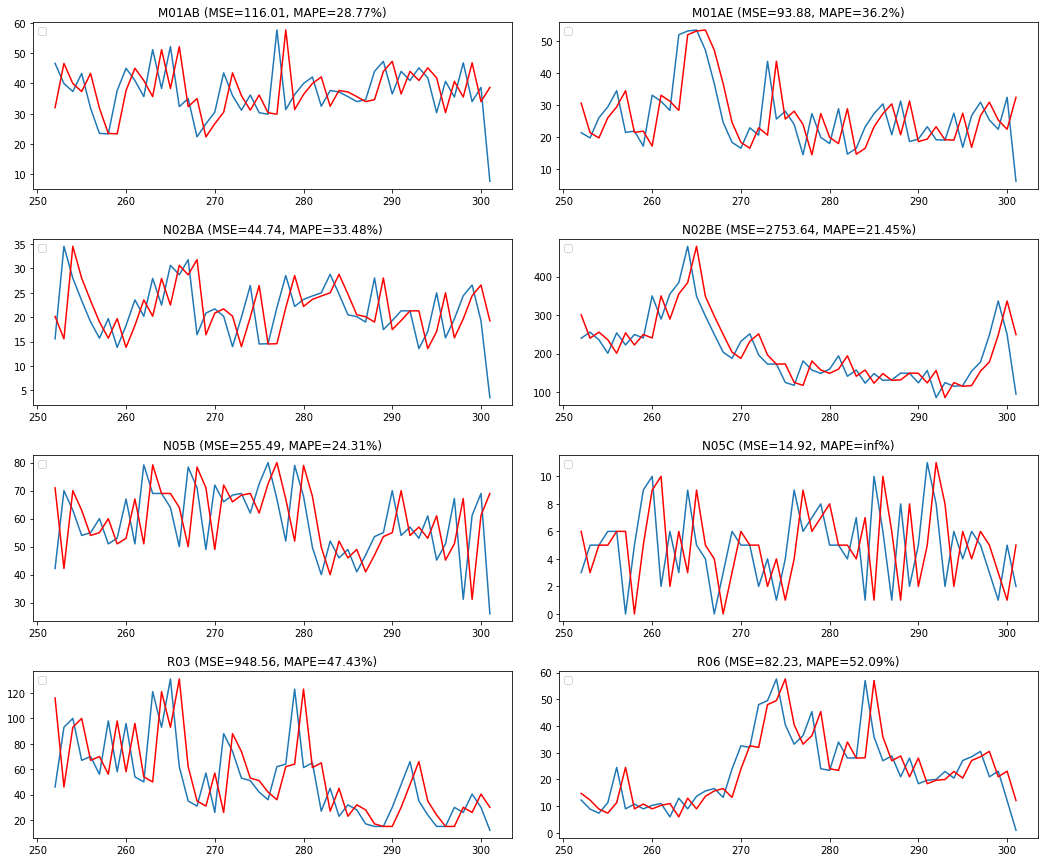

In [18]:
df=pd.read_csv('salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ds=df[x]
    dataframe = concat([ds.shift(1), ds], axis=1)
    dataframe.columns = ['t+1', 't-1']
    size = len(dataframe)-50
    X=dataframe['t-1']
    Y=dataframe['t+1']
    test, predictions = X[size:len(X)], Y[size:len(Y)]
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Naive MSE',x]=error
    resultsRollingdf.loc['Naive MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

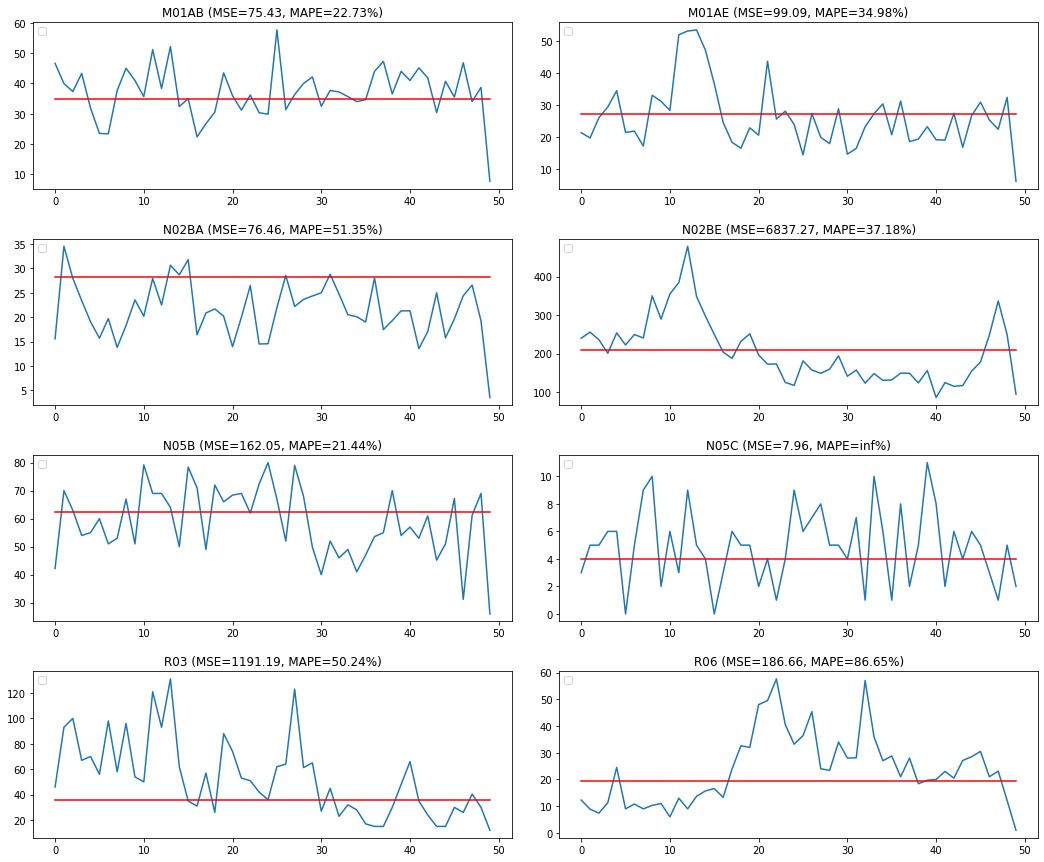

In [19]:
df=pd.read_csv('salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-50
    test = X[size:len(X)] 
    mean = np.mean(X[0:size])
    predictions = np.full(50,mean)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsLongtermdf.loc['Average MSE',x]=error
    resultsLongtermdf.loc['Average MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

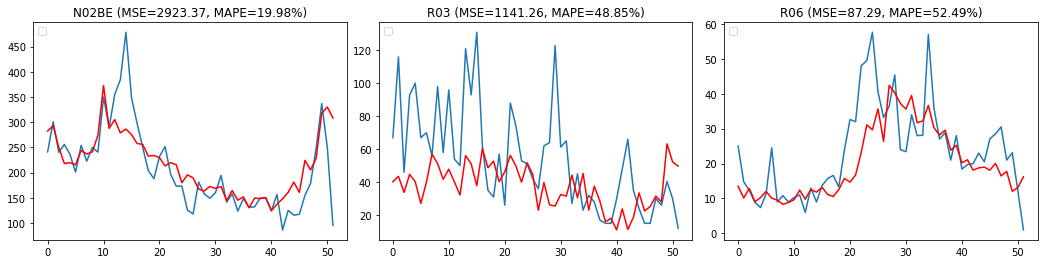

In [20]:
df=pd.read_csv('salesweekly.csv')
subplotindex=0
numrows=1
numcols=3
fig, ax = plt.subplots(numrows, numcols, figsize=(18,4))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['N02BE','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-52
    test = X[size:len(X)]
    train = X[0:size]
    predictions=list()
    history = [x for x in train]
    for i in range(len(test)):
        obs=list()
        for y in range(1,5):
            obs.append(train[-(y*52)+i])
        yhat = np.mean(obs)
        predictions.append(yhat)
        history.append(test[i])
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Seasonal Naive MSE',x]=error
    resultsRollingdf.loc['Seasonal Naive MAPE',x]=perror
    ax[colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[colindex].plot(test)
    ax[colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()    

In [21]:
import statsmodels.api as sm
df=pd.read_csv('salesweekly.csv')
warnings.filterwarnings("ignore")
for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    resDiff = sm.tsa.arma_order_select_ic(df[x], max_ar=5, max_ma=5, ic='aic', trend='c')
    print('ARMA(p,q,'+x+') =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q,M01AB) = (3, 3) is the best.
ARMA(p,q,M01AE) = (2, 0) is the best.
ARMA(p,q,N02BA) = (3, 3) is the best.
ARMA(p,q,N02BE) = (2, 2) is the best.
ARMA(p,q,N05B) = (4, 3) is the best.
ARMA(p,q,N05C) = (3, 3) is the best.
ARMA(p,q,R03) = (1, 1) is the best.
ARMA(p,q,R06) = (2, 2) is the best.


In [22]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(f, dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print(f+' - Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

warnings.filterwarnings("ignore")

df=pd.read_csv('salesweekly.csv')

for f in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    evaluate_models(f, df[f].values, p_values, d_values, q_values)

M01AB - Best ARIMANone MSE=inf
M01AE - Best ARIMANone MSE=inf
N02BA - Best ARIMANone MSE=inf
N02BE - Best ARIMANone MSE=inf
N05B - Best ARIMANone MSE=inf
N05C - Best ARIMANone MSE=inf
R03 - Best ARIMANone MSE=inf
R06 - Best ARIMANone MSE=inf


In [23]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) - 50)
    train, test = X[0:train_size], X[train_size:]
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    forecast = model_fit.predict(1,len(test))
    error = mean_squared_error(test, forecast)
    return error

def evaluate_models(f, dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print(f+' - Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

warnings.filterwarnings("ignore")

for f in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    evaluate_models(f, df[f].values, p_values, d_values, q_values)

M01AB - Best ARIMANone MSE=inf
M01AE - Best ARIMANone MSE=inf
N02BA - Best ARIMANone MSE=inf
N02BE - Best ARIMANone MSE=inf
N05B - Best ARIMANone MSE=inf
N05C - Best ARIMANone MSE=inf
R03 - Best ARIMANone MSE=inf
R06 - Best ARIMANone MSE=inf


In [25]:
from statsmodels.tsa.arima.model import ARIMA  # Import updated ARIMA class

df = pd.read_csv('salesweekly.csv')

# ... rest of your code ...

for x in [M01AB, M01AE, N02BA, N02BE, N05B, N05C, R03, R06]:
    X = df[x['series']].values
    size = len(X) - 50
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(x['p'], x['d'], x['q']))  # Use updated ARIMA class
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    # ... (rest of your code to calculate errors and plot) ...



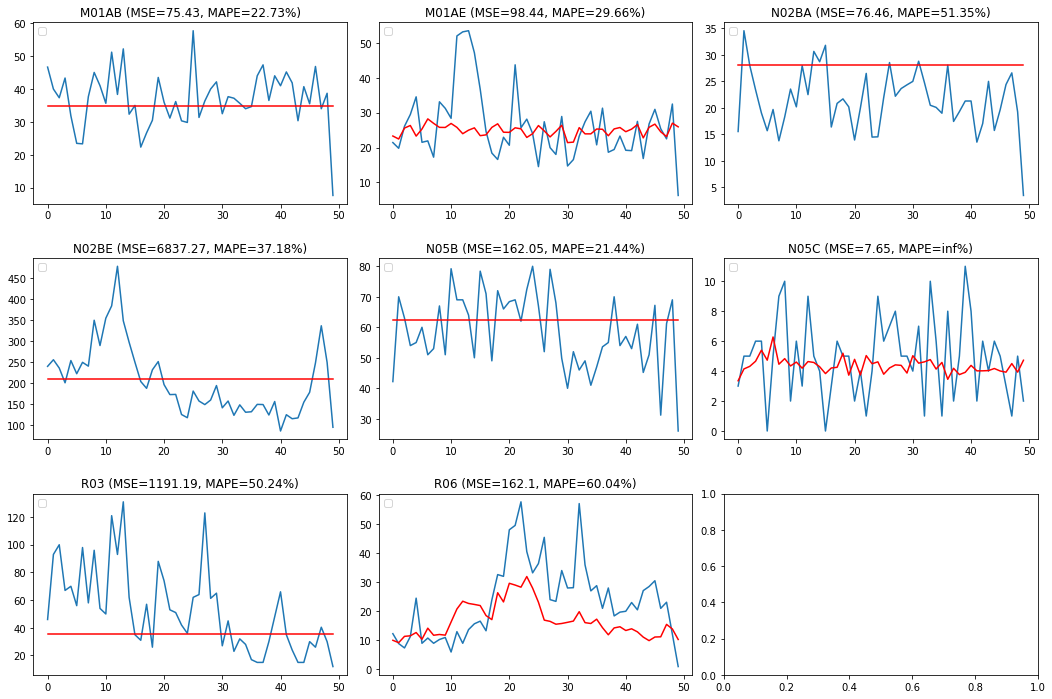

In [26]:
df=pd.read_csv('salesweekly.csv')

M01AB= {'series':'M01AB','p':0,'d':0,'q':0}
M01AE= {'series':'M01AE','p':4,'d':0,'q':4}
N02BA= {'series':'N02BA','p':0,'d':0,'q':0}
N02BE= {'series':'N02BE','p':0,'d':0,'q':0}
N05B= {'series':'N05B','p':0,'d':0,'q':0}
N05C= {'series':'N05C','p':2,'d':0,'q':2}
R03= {'series':'R03','p':0,'d':0,'q':0}
R06= {'series':'R06','p':2,'d':0,'q':2}

subplotindex=0
numrows=3
numcols=3
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in [M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x['series']].values
    size = int(len(X) - 50)
    train, test = X[0:size], X[size:len(X)]
    model = ARIMA(train, order=(x['p'],x['d'],x['q']))
    model_fit = model.fit()
    forecast = model_fit.predict(1,len(test))
    error = mean_squared_error(test, forecast)
    perror = mean_absolute_percentage_error(test, forecast)
    resultsLongtermdf.loc['ARIMA MSE',x['series']]=error
    resultsLongtermdf.loc['ARIMA MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(forecast, color='red')
    subplotindex=subplotindex+1
plt.show()

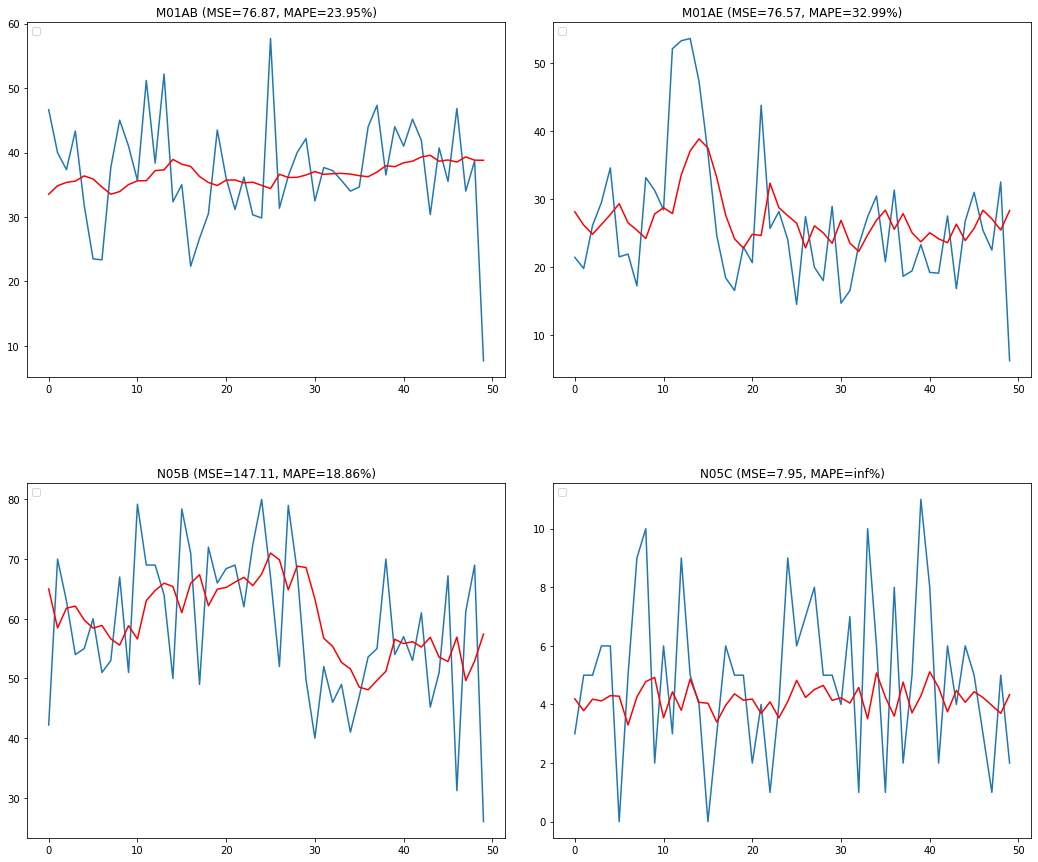

In [27]:
from pmdarima import auto_arima

df=pd.read_csv('salesweekly.csv')
subplotindex=0
numrows=2
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in ['M01AB','M01AE','N05B','N05C']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x].values
    size = len(X)-50
    train, test = X[0:size], X[size:len(X)]
    history = [c for c in train]
    predictions = list()
    for t in range(len(test)):
        if (x=='N02BA' or x=='N02BE' or x=='R03' or x=='R06'):
            model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=52, max_d=1, max_D=1,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, seasonal=True,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)
        else:
            model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, max_d=1,
                           trace=False, seasonal=False,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)
        model_fit = model.fit(history)
        output = model_fit.predict(n_periods=1)
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['AutoARIMA MSE',x]=error
    resultsRollingdf.loc['AutoARIMA MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()


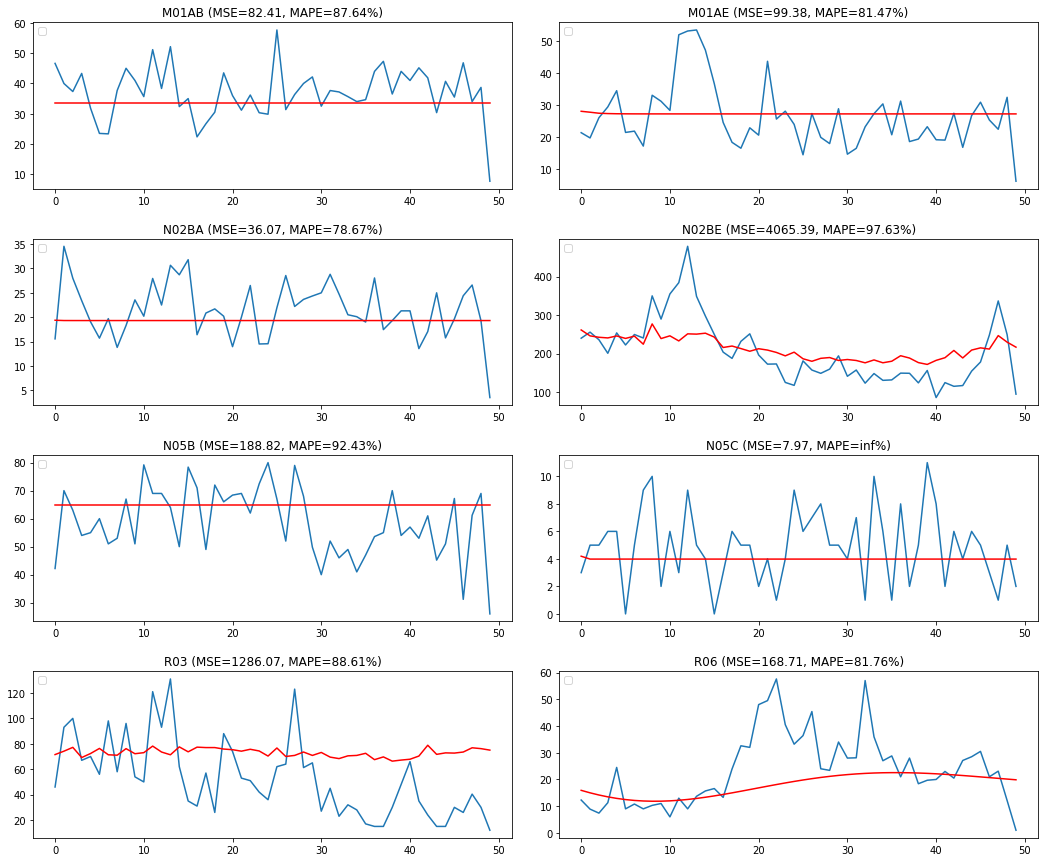

In [28]:
from pmdarima import auto_arima

df=pd.read_csv('salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x].values
    size = int(len(X) - 50)
    train, test = X[0:size], X[size:len(X)]
    if (x=='N02BE' or x=='R03' or x=='R06'):
        model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=52, max_d=1, max_D=1,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, seasonal=True,
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    else:
        model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, max_d=1,
                           trace=False, seasonal=False,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)
    model_fit = model.fit(train)
    forecast = model_fit.predict(n_periods=len(test))
    error = mean_squared_error(test, forecast)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsLongtermdf.loc['AutoARIMA MSE',x]=error
    resultsLongtermdf.loc['AutoARIMA MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(forecast, color='red')
    subplotindex=subplotindex+1
plt.show()

In [29]:
pip install fbprophet

Note: you may need to restart the kernel to use updated packages.Collecting fbprophet
  Using cached fbprophet-0.7.1.tar.gz (64 kB)

  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached pystan-3.9.0-py3-none-any.whl (13 kB)

  ERROR: Command errored out with exit status 1:
   command: 'D:\Anaconda\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Vraj Pc\\AppData\\Local\\Temp\\pip-install-_uzd54q6\\fbprophet_9ff5f4d9e9294dfab14b2551800f3819\\setup.py'"'"'; __file__='"'"'C:\\Users\\Vraj Pc\\AppData\\Local\\Temp\\pip-install-_uzd54q6\\fbprophet_9ff5f4d9e9294dfab14b2551800f3819\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Vraj Pc\AppData\Local\Temp\pip-wheel-ueeau5vr'
       cwd: C:\Users\Vraj Pc\AppData\Local\Temp\pip-install-_uzd54q6\fbprophet_9ff5f4d9e9294dfab14b2551800f3819\
  Complete output (336 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\


  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached holidays-0.42-py3-none-any.whl (917 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)
  Using cached pystan-3.8.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.7.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.6.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.5.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.4.0-py3-none-any.whl (13 kB)
  Using cached pysimdjson-3.2.0-cp39-cp39-win_amd64.whl (157 kB)
  Using cached pystan-3.3.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.2.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.1.1-py3-none-any.whl (13 kB)
  Using cached pystan-3.1.0-py3-none-any.whl (13 kB)
  Using cached pystan-3.0.2-py3-none-any.whl (13 kB)
  Using cached pystan-3.0.1-py3-none-any.whl (12 kB)
  Using cached pystan-3.0.0-py3-none-any.whl (12 kB)
  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Running setup.


    File "<string>", line 1, in <module>
    File "C:\Users\Vraj Pc\AppData\Local\Temp\pip-install-_uzd54q6\fbprophet_9ff5f4d9e9294dfab14b2551800f3819\setup.py", line 122, in <module>
      setup(
    File "D:\Anaconda\lib\site-packages\setuptools\__init__.py", line 87, in setup
      return distutils.core.setup(**attrs)
    File "D:\Anaconda\lib\site-packages\setuptools\_distutils\core.py", line 148, in setup
      return run_commands(dist)
    File "D:\Anaconda\lib\site-packages\setuptools\_distutils\core.py", line 163, in run_commands
      dist.run_commands()
    File "D:\Anaconda\lib\site-packages\setuptools\_distutils\dist.py", line 967, in run_commands
      self.run_command(cmd)
    File "D:\Anaconda\lib\site-packages\setuptools\dist.py", line 1214, in run_command
      super().run_command(command)
    File "D:\Anaconda\lib\site-packages\setuptools\_distutils\dist.py", line 986, in run_command
      cmd_obj.run()
    File "D:\Anaconda\lib\site-packages\wheel\bdist_wheel.py", l

  Running setup.py clean for pystan
Failed to build fbprophet pystan
    Running setup.py install for pystan: started
    Running setup.py install for pystan: finished with status 'error'


    File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
    File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
    File "<frozen importlib._bootstrap>", line 680, in _load_unlocked
    File "<frozen importlib._bootstrap_external>", line 850, in exec_module
    File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
    File "D:\Anaconda\lib\site-packages\pandas\core\arrays\__init__.py", line 1, in <module>
      from pandas.core.arrays.base import (
    File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
    File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
    File "<frozen importlib._bootstrap>", line 680, in _load_unlocked
    File "<frozen importlib._bootstrap_external>", line 850, in exec_module
    File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
    File "D:\Anaconda\lib\site-packages\pandas\core\arrays\base.py", line 68, in <module>
      from pandas.c

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\coroutine\all.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\coroutine
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\coroutine\asymmetric_coroutine.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\coroutine
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\coroutine\attributes.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\coroutine
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\coroutine\coroutine.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\coroutine
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\coroutine\exceptions.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\coroutine
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\coroutine\flags.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\detail\winapi\time.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\detail\winapi
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\detail\winapi\timers.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\detail\winapi
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\detail\winapi\tls.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\detail\winapi
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\detail\winapi\wait.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\detail\winapi
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\detail\winapi\waitable_timer.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\detail\winapi
  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\detail\winapi\detail
  copying pystan\stan\li

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\detail\nested_than.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\detail\nested_than_fwd.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\detail\nested_to.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\detail\nested_to_fwd.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\detail\preprocessor.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hana\detail\std_common_type.hpp -> build\lib.win-amd64-3.9\py

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hof\capture.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hof
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hof\combine.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hof
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hof\compose.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hof
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hof\config.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hof
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hof\construct.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hof
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hof\decay.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hof
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\hof\decorate

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\msm\front\euml\container.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\msm\front\euml
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\msm\front\euml\euml.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\msm\front\euml
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\msm\front\euml\euml_typeof.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\msm\front\euml
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\msm\front\euml\guard_grammar.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\msm\front\euml
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\msm\front\euml\iteration.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\msm\front\euml
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\msm\front\euml\operator.hpp -> build\lib.win-

  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multiprecision\cpp_bin_float.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multiprecision
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multiprecision\cpp_complex.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multiprecision
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multiprecision\cpp_dec_float.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multiprecision
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multiprecision\cpp_int.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multiprecision
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multiprecision\debug_adaptor.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multiprecision
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\multiprecision\eigen.hpp -> build\

  creating build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma\detail\alternative_function.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma\detail\as.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma\detail\attributes.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma\detail\default_width.hpp -> build\lib.win-amd64-3.9\pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma\detail
  copying pystan\stan\lib\stan_math\lib\boost_1.69.0\boost\spirit\home\karma\detail\en

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [31]:
df=pd.read_csv('salesweekly.csv')

M01AB= {
    'series':'M01AB',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[10,30,50],
               'interval_width':[0.0005]
              }
}
M01AE= {
    'series':'M01AE',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],
               'interval_width':[0.0005]
              }
}
N02BA= {
    'series':'N02BA',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.005,0.01,0.05,0.1],
                   'interval_width':[0.0005]
              }
}
N02BE= {
    'series':'N02BE',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[5,10,50],'seasonality_prior_scale':[150,170,200],
               'interval_width':[0.0005]
              }
}
N05B= {
    'series':'N05B',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[1,5,10],
               'interval_width':[0.0005]
              }
}
N05C= {
    'series':'N05C',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.05,0.08,0.1,0.5],
               'interval_width':[0.0005]
              }
}
R03= {
    'series':'R03',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[120,160,200],
               'interval_width':[0.0005]
              }
}
R06= {
    'series':'R06',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[100,120,160,200],
               'interval_width':[0.0005]
              }
}

r=[M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]
warnings.filterwarnings("ignore")

for x in r:
    dfg=df[['datum',x['series']]]
    dfg = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
    size = int(len(dfg) - 50)
    dfgtrain=dfg.loc[0:size,:]
    dfgtest=dfg.loc[size+1:len(dfg),:]
    predictions = list()
    minError=0
    grid = ParameterGrid(x['params_grid'])
    for p in grid:
        model = fbprophet.Prophet(**p, daily_seasonality=False, weekly_seasonality=False)
        if(x['series']=='N02BE' or x['series']=='R03' or x['series']=='R06'):
            model=model.add_seasonality(
                                name='yearly',
                                period=365.25,
                                fourier_order=13)
        model_fit = model.fit(dfgtrain)
        future = model.make_future_dataframe(periods=50, freq='W')
        output = model.predict(future)
        predictions=output.loc[size+2:len(dfg),:]['yhat'].values
        error = mean_squared_error(dfgtest['y'].values, predictions)
        if(minError>0):
            if(error<minError):
                minError=error
                minP=p
        else:
            minError=error
            minP=p

    print(minP)
    print('Test MSE ('+x['series']+'): %.3f' % minError)

NameError: name 'fbprophet' is not defined